In [1]:
import pandas as pd
import numpy as np

Mounted at /content/drive


In [3]:
import zipfile
import os
import pandas as pd

# Path to the zip file
zip_file_path = '/dataset/places365_contents.zip'

# Directory to extract the contents
extracted_dir = 'data_contents/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Create a list to store dataframe rows
data = []

# Traverse through the extracted directory to create the dataframe
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            label_name = os.path.basename(root)
            data.append({'path': file_path, 'name': file, 'label': label_name})

# Create a DataFrame
df = pd.DataFrame(data)

# Adjust path format for 'path name' column
df['path name'] = 'data_contents/' + df['label'] + '/' + df['name']

# Rearrange columns
df = df[['path name', 'name', 'label']]

# Print the DataFrame
print(df)

                                       path name          name           label
0      data_contents/airplane_cabin/00001816.jpg  00001816.jpg  airplane_cabin
1      data_contents/airplane_cabin/00004085.jpg  00004085.jpg  airplane_cabin
2      data_contents/airplane_cabin/00000791.jpg  00000791.jpg  airplane_cabin
3      data_contents/airplane_cabin/00003298.jpg  00003298.jpg  airplane_cabin
4      data_contents/airplane_cabin/00004267.jpg  00004267.jpg  airplane_cabin
...                                          ...           ...             ...
62515     data_contents/locker_room/00004670.jpg  00004670.jpg     locker_room
62516     data_contents/locker_room/00000447.jpg  00000447.jpg     locker_room
62517     data_contents/locker_room/00004992.jpg  00004992.jpg     locker_room
62518     data_contents/locker_room/00004374.jpg  00004374.jpg     locker_room
62519     data_contents/locker_room/00003852.jpg  00003852.jpg     locker_room

[62520 rows x 3 columns]


In [4]:
df['label'].value_counts()

airplane_cabin          5000
ballroom                5000
childs_room             5000
hospital_room           5000
swimming_pool-indoor    5000
amusement_arcade        5000
garage-indoor           5000
dining_hall             5000
bakery-shop             5000
art_gallery             5000
locker_room             5000
sauna                   4020
bank_vault              3500
Name: label, dtype: int64

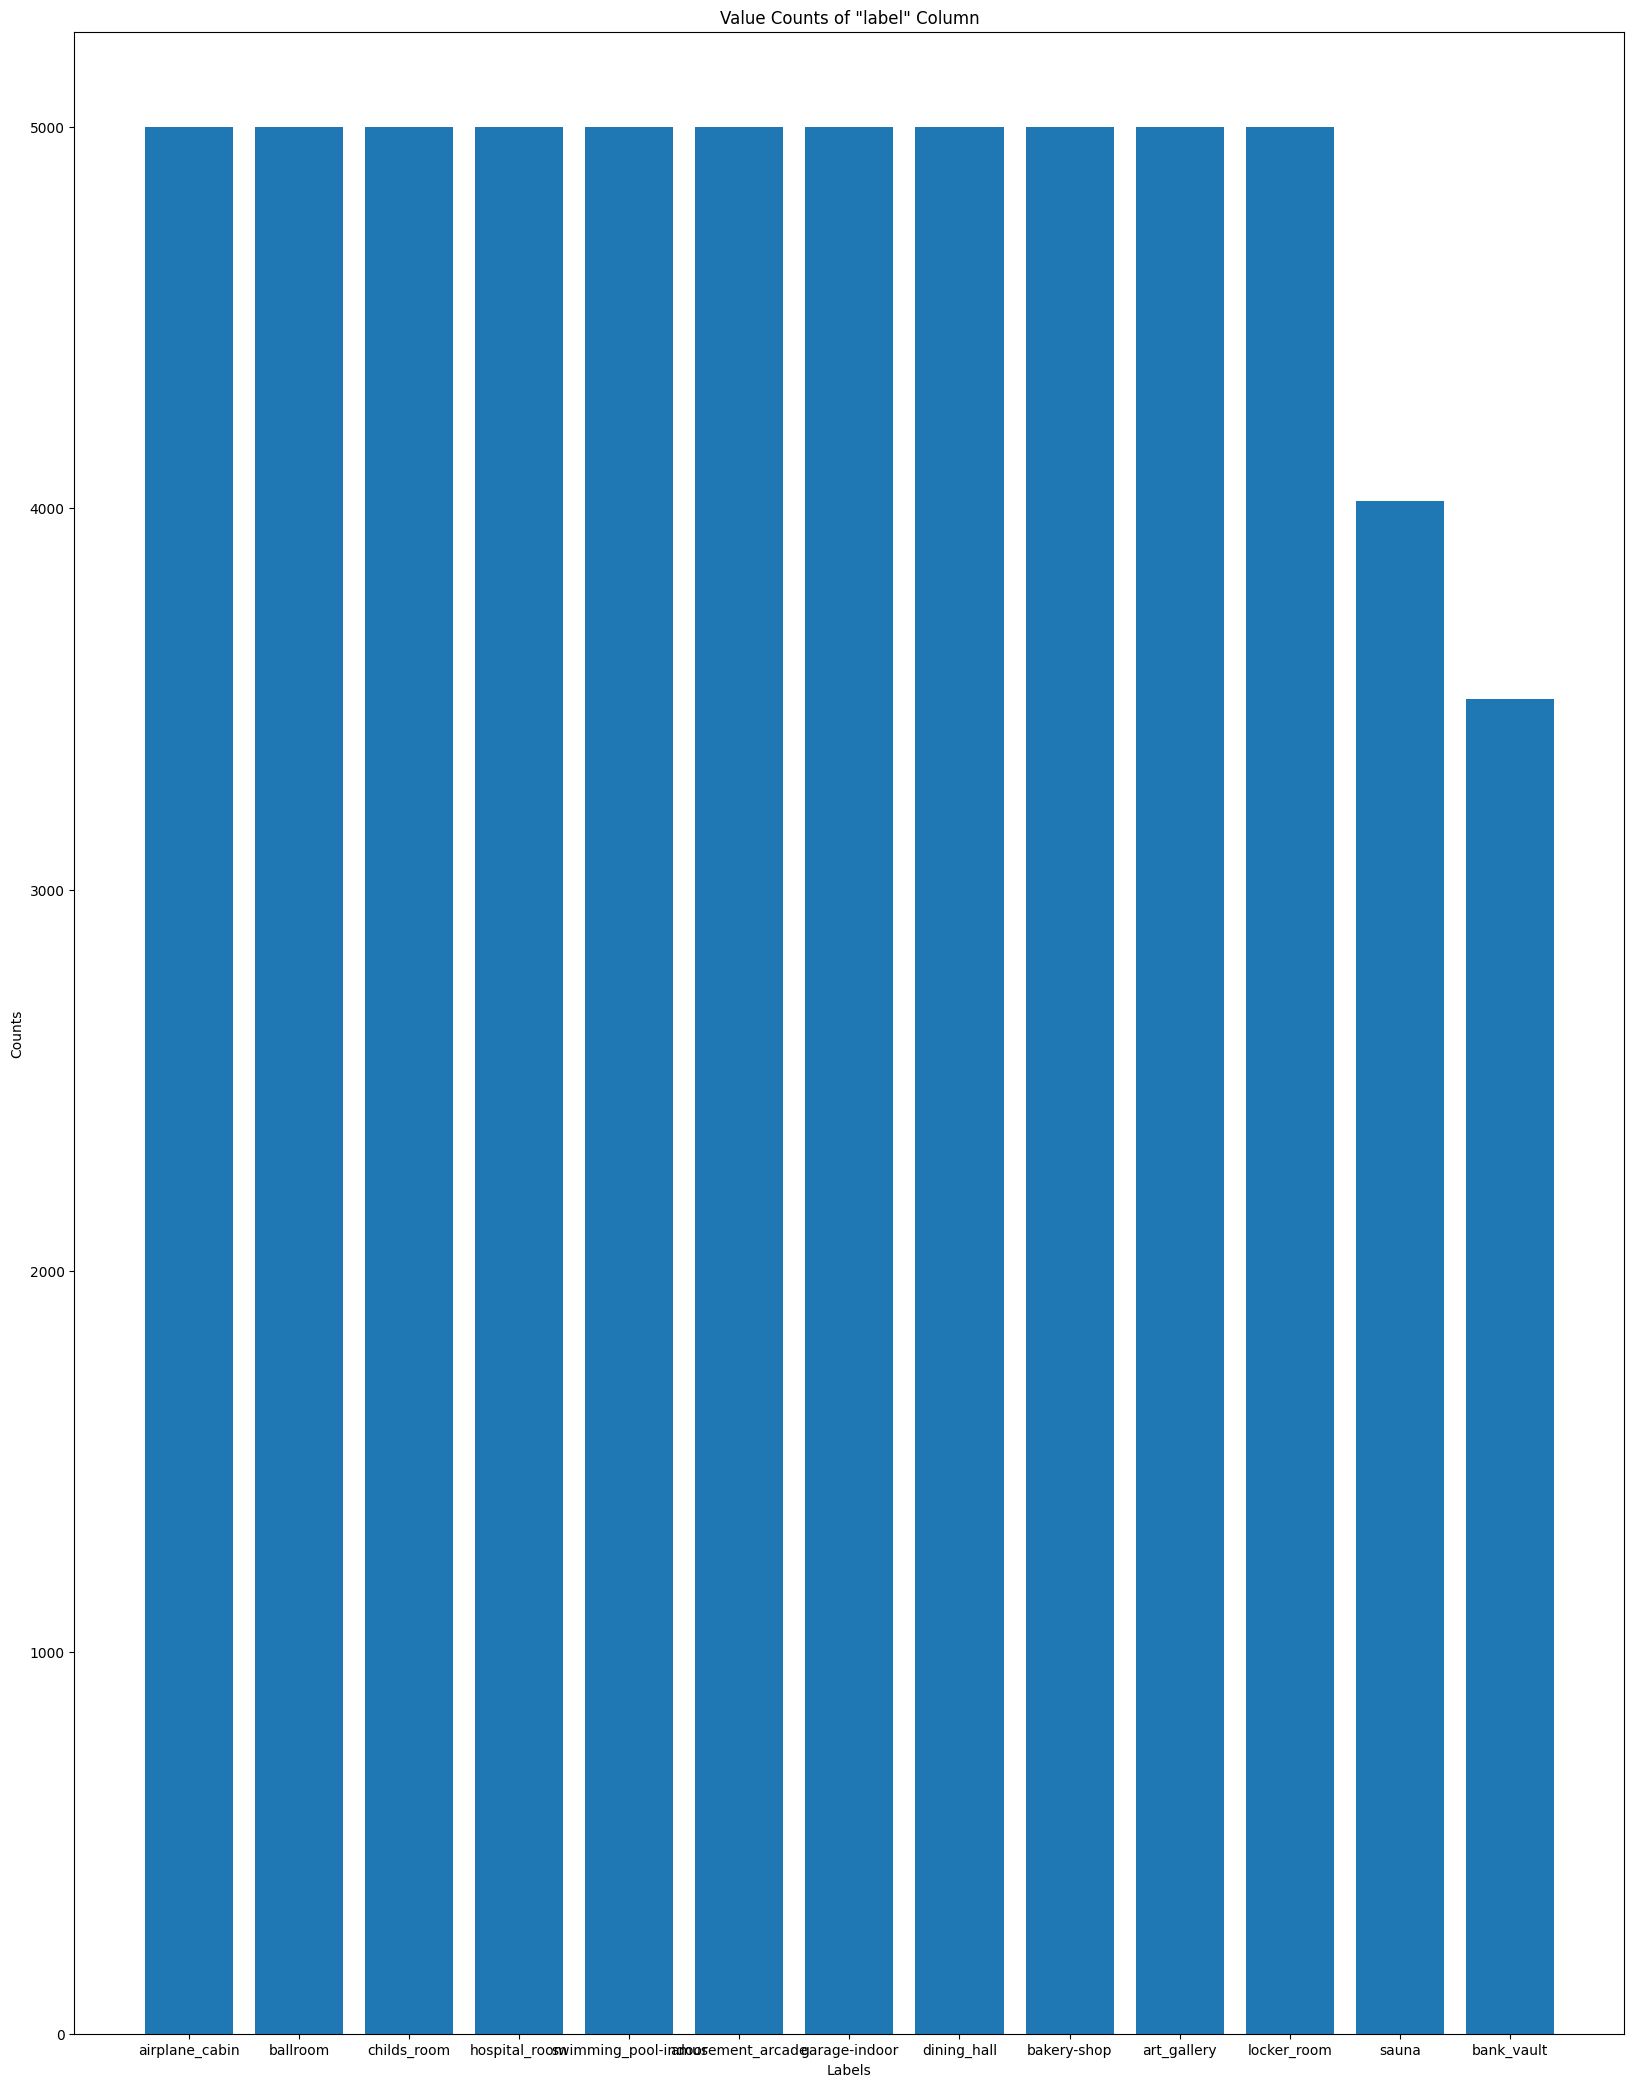

In [5]:
import matplotlib.pyplot as plt

# Assuming 'label' is the column you want to plot
value_counts = df['label'].value_counts()
plt.figure(figsize=(20, 26))

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Value Counts of "label" Column')

# Show the plot
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 56, 56, 64)        256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 56, 56, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0

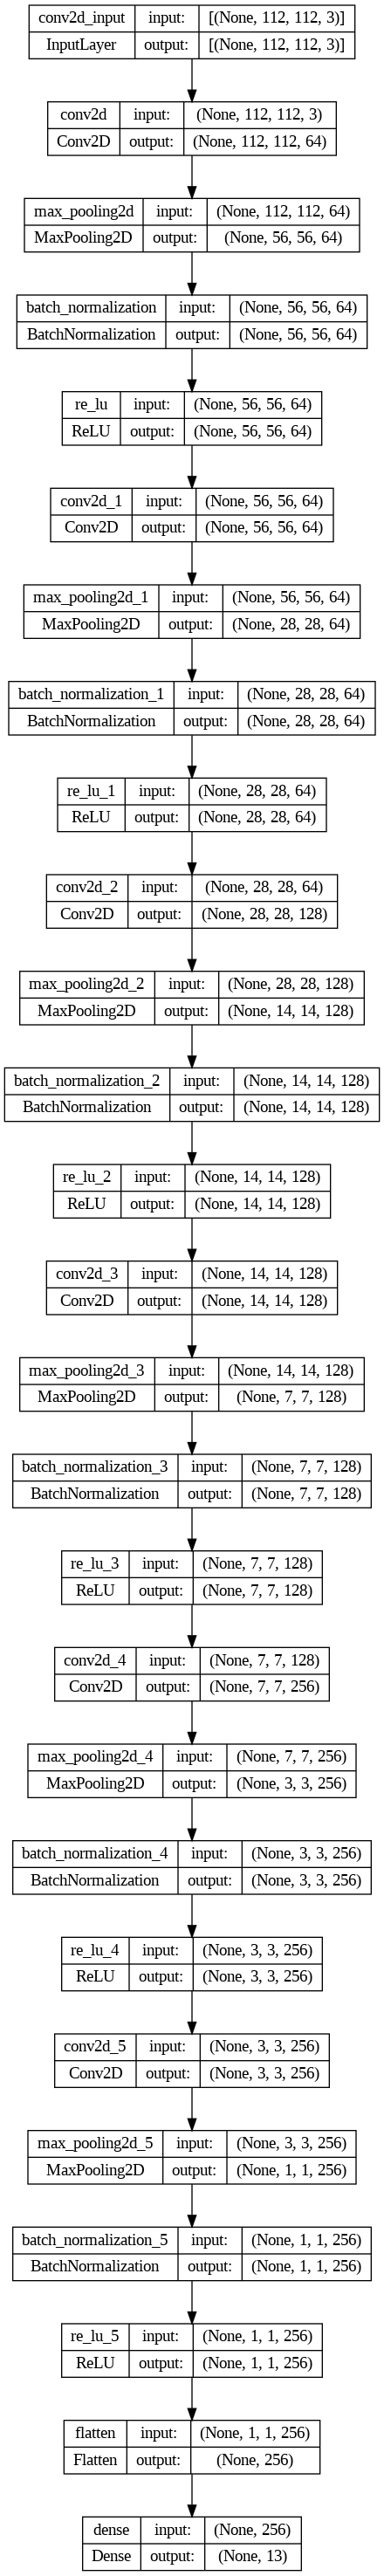

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model



def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Conv2D(64, (3, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Conv2D(128, (3, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Conv2D(128, (3, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Conv2D(256, (3, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Conv2D(256, (3, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        ReLU(),

        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (112, 112, 3)  # Change this according to your data
num_classes = 13  # Change this to the correct number of classes

# Create the model
model = create_model(input_shape, num_classes)

# Print the model summary
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
# Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Data augmentation: random rotations
    width_shift_range=0.2,  # Data augmentation: random width shifts
    height_shift_range=0.2,  # Data augmentation: random height shifts
    horizontal_flip=True,  # Data augmentation: horizontal flips
)
batch_size = 32
# Load and preprocess training data from DataFrame
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='path name',  # Column containing image paths
    y_col='label',  # Column containing labels
    target_size=(112, 112),  # Resize images to match model input size
    batch_size=batch_size,
    class_mode='categorical',  # Categorical labels for multi-class classification
)

# Load and preprocess validation data from DataFrame
validation_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='path name',
    y_col='label',
    target_size=(112, 112),
    batch_size=batch_size,
    class_mode='categorical',
)


Found 50016 validated image filenames belonging to 13 classes.
Found 12504 validated image filenames belonging to 13 classes.


In [9]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,

)


#model = load_model('/model/model_100_epochs.h5')

Epoch 1/100
1563/1563 [==============================] - 3185s 2s/step - loss: 1.6097 - accuracy: 0.4855 - val_loss: 1.4621 - val_accuracy: 0.5300
Epoch 2/100
1391/1563 [=========================>....] - ETA: 5:13 - loss: 1.1988 - accuracy: 0.6213

In [ ]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Save the model
#model.save('/model/model_200_epochs.h5')  # Adjust the filename as needed

NameError: ignored